In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

from bgu_utils import train_q_learning_agent, moving_average, episode_weighted_reward
import nevergrad as ng  #pip install nevergrad


env = gym.make("FrozenLake-v0")

### Apply Bayesian Optimization to find optimal hyperparameters configuration 

In [3]:
def optimize_hyperparameters(epsilon, alpha, discount, epsilon_decay):
    """We want to maximize this function"""
    _, rewards_per_episode, _ = train_q_learning_agent(env, epsilon, alpha, discount, epsilon_decay, debug=False)
    return episode_weighted_reward(rewards_per_episode)

# Bounded region of parameter space
pbounds = {'epsilon': (0.5, 1), 'epsilon_decay': (0.99, 0.999), 'alpha': (0.1, 0.9), 'discount': (0.5, 0.9)}


optimizer = ng.optimizers.BayesianOptimization(
    f=optimize_hyperparameters,
    pbounds=pbounds)


# probe some default values
optimizer.probe(params={"epsilon": 0.5, "epsilon_decay": 0.998, "alpha": 0.1, "discount": 0.9},
                lazy=True)
optimizer.probe(params={"epsilon": 0.5, "epsilon_decay": 0.998, "alpha": 0.9, "discount": 0.9},
                lazy=True)

optimizer.maximize(init_points=1, n_iter=2)

|   iter    |  target   |   alpha   | discount  |  epsilon  | epsilo... |
-------------------------------------------------------------------------
|  1        |  0.02261  |  0.1      |  0.9      |  0.5      |  0.998    |
|  2        |  0.02394  |  0.9      |  0.9      |  0.5      |  0.998    |
|  3        |  0.01279  |  0.2511   |  0.6742   |  0.6877   |  0.9955   |
|  4        |  0.01334  |  0.9      |  0.9      |  1.0      |  0.999    |
|  5        |  0.0      |  0.9      |  0.9      |  0.5      |  0.99     |


In [11]:
q_table, rewards_per_episode, steps_to_goal, q500, q2000 = train_q_learning_agent(env, 
                                                                       optimizer.max["params"]['epsilon'], 
                                                                       optimizer.max["params"]['alpha'], 
                                                                       optimizer.max["params"]['discount'], 
                                                                       optimizer.max["params"]['epsilon_decay'])

In [12]:
print("params used for training", optimizer.max["params"])

params used for training {'alpha': 0.9, 'discount': 0.9, 'epsilon': 0.5, 'epsilon_decay': 0.998}


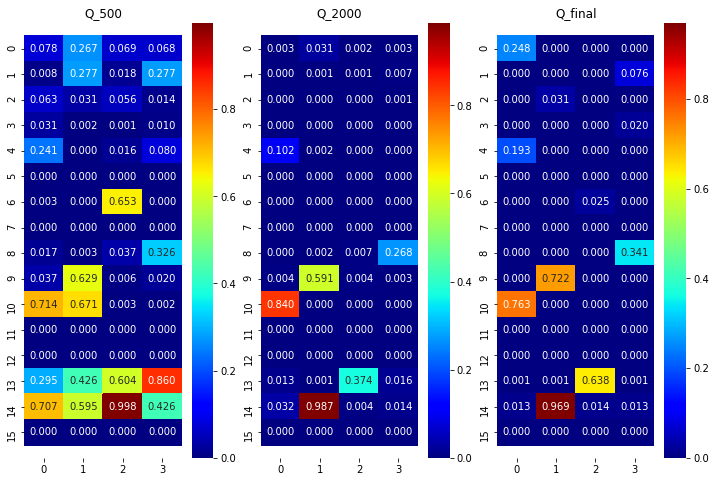

In [13]:
plt.figure(figsize=(12, 8))
titles = ["Q_500", "Q_2000", "Q_final"]
Q = [q500, q2000, q_table]

for i in range(3):
    plt.subplot(1,3,i+1)
    seaborn.heatmap(Q[i], annot=True, fmt=".3f", cmap="jet")
    plt.ylim([16.5, -.5]);
    plt.title(titles[i]);

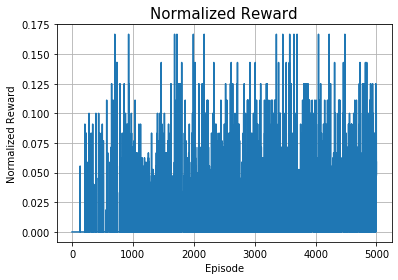

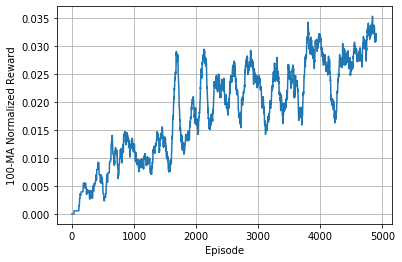

In [14]:
plt.plot(rewards_per_episode)
plt.grid(True)
plt.xlabel("Episode")
plt.ylabel("Normalized Reward");

plt.title("Normalized Reward", fontsize=15)

plt.figure()

plt.plot(moving_average(rewards_per_episode, 100))
plt.grid(True)
plt.xlabel("Episode")
plt.ylabel("100-MA Normalized Reward");

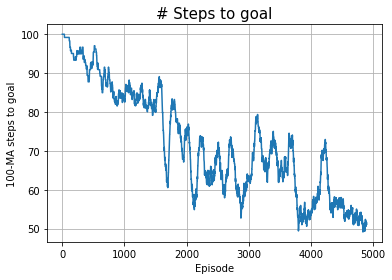

In [15]:
plt.plot(moving_average(steps_to_goal, 100))
plt.grid(True)
plt.xlabel("Episode")
plt.ylabel("100-MA steps to goal");
plt.title("# Steps to goal", fontsize=15);

## Part 2 - DQN 

In [1]:
import gym
from dqn_utils import DQNAgent
import numpy as np
import matplotlib.pyplot as plt
from bgu_utils import moving_average

%matplotlib inline
env = gym.make("CartPole-v1")

Using TensorFlow backend.
c:\projects\buildots\pycode\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\projects\buildots\pycode\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\projects\buildots\pycode\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\projects\buildots\pycode\venv\lib\site-packages\tenso

In [2]:
agent = DQNAgent(env, discount=0.95, minibatch_size=32, use_tensorboard=True, weights=None)

In [ ]:
ep_rewards, ep_avg_loss = agent.train(episodes=5_000, epsilon=1., epsilon_decay=0.999, show_every=1000)

  0%|                                                                                   | 0/5000 [00:00<?, ?episodes/s]

  2%|#6                                                                     | 113/5000 [02:26<2:45:40,  2.03s/episodes]

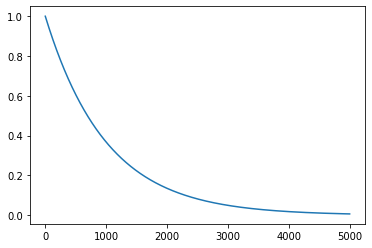

In [7]:
e = np.zeros(5000)
e[0] = 1
for i in range(1, 5000):
    e[i] = e[i-1] * 0.999
    
plt.plot(e)

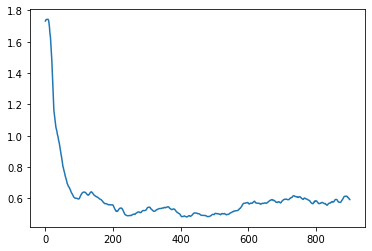

In [4]:
plt.plot(moving_average(ep_avg_loss, 100))

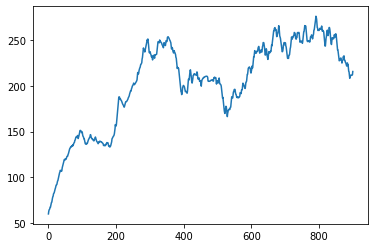

In [7]:
plt.plot(moving_average(ep_rewards, 100))

In [17]:
agent.model.load_weights("dqn3.h5")

(array([-0.27829804,  3.53338101,  3.68169474,  9.87507875]), 0.0)

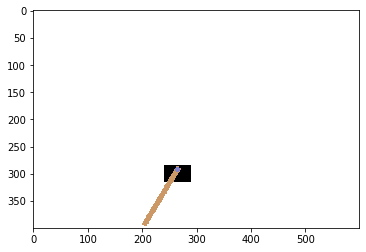

In [75]:
new_state, reward, done, p = env.step(1)
plt.imshow(env.render(mode="rgb_array"))
new_state, reward